# TO DO
+ Add non-local hash function √


+ add cross validation
+ add MNIST
+ add IP addresses 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr, kendalltau
import pandas as pd
import os
T = np.transpose
from hashfunctions import *
os.chdir('/Users/tim/py_code/')
from bloom_filters import * 
import sys
sys.path.append('/Users/tim/py_code/FLY_LSH')
from read_data import *

# import hashlib # might need

max_val_hash = sys.maxsize
import xxhash
import compute_distance_metrics

# get MNIST
mnist_path = '/Users/tim/py_code/FLY_LSH/mnist10k.txt'
mnist = read_generic_data(mnist_path,10000,28*28) # 10 000, 784




In [127]:
dat_use = 'MNIST' # Hallem, rand100
# dat_use = 'rand100' # 10, 24, 100
n_ex = 1000
l_ex = 500

proj = 'SB4'  # {'DG','SB4','SB5'}
dist_met = 'cos' # {'euc','cos'}
cor_fun = kendalltau
cor_str = '$\tau$'

eps = .01 # [.01, 6E-6]

# KC projection parameters
# m= 2753 
# k= 17
# m= 1055
# k=6
# m = 959
# k = 6
# m = 350
# k = 17
# m = 135
# k = 7

os.chdir('/Users/tim/py_code/FLY_LSH/fly_dat/')
dat = pd.read_csv("hallem1.txt",delimiter=' ')
if dat_use == 'Hallem':
    dat = dat.values
elif dat_use[:4] == 'rand':
    dIn = int(dat_use[4:])
    dat = np.random.randn(l_ex,dIn) # random data
elif dat_use == 'MNIST':
#     assert(0,'Need To add Functionallity')
    dIn = 28*28
    dat = mnist[:l_ex,:]
    
n_odors = np.shape(dat)[0]
dat_100 = dat/np.mean(dat,axis=0)*100
dat_100 = np.nan_to_num(dat_100)
U = dat_100
assert(np.shape(U)[0]==l_ex)

/Users/tim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


In [128]:
# ORN space functions
def novelty_dist(S,q):
    if dist_met == 'cos':
        cs = -(np.max([cos_sim(s,q) for s in S])-1)
    elif dist_met == 'cor':
        cs = -(np.max([cor_sim(s,q) for s in S])-1)
    elif dist_met == 'euc':
        cs = np.min([euc_sim(s,q) for s in S])
    return cs

def cos_sim(a,b):
    return np.dot(a,b)/(np.sqrt(np.sum(a**2)) * np.sqrt(np.sum(b**2)))
def cor_sim(a,b):
    a = a-np.mean(a)
    b = b-np.mean(b)
    return np.dot(a,b)/(np.sqrt(np.sum(a**2)) * np.sqrt(np.sum(b**2)))  
def euc_sim(a,b):
    return np.sqrt(np.sum((a-b)**2))
def tag_cnt(S,q):
    return np.max([np.sum(s[q==1]) for s in S])

# hash function
def get_hash(v,m,k):
    # using v, get k hashes in range [0,m]
    val = np.sum(v)
    this_hash = (np.array([xxhash.xxh32(str(val+i)).intdigest() for i in range(k)])-mn_hash)/(mx_hash-mn_hash)
    return this_hash*m

def hash_array(A,m,k):
    shp = np.shape(A)
    if len(shp)==2:
        B = list()
        for i in range(shp[0]):
            B.append(get_hash(A[i],m,k))
    elif len(shp)==3: # recursive approach
        B = list()
        for i in range(shp[0]):
            B.append(hash_array(A[i],m,k))
    return  np.array(B).astype(int)

# utility functions 
def min_m(n,eps):
    return int(np.ceil(n*np.log2(np.e)*np.log2(1/eps)))
def opt_k(m,n):
    return int(np.floor(np.log(2)*m/n))
def e_eps(m,k,n):
    # From Broder&Mitenmacher2004
    p = (1.0-1.0/m)**(k*n)
    return (1-p)**k

In [129]:
# random selection... old guard
# np.shape(U) # 111 odors x 24 ORNs
# tag_ind = np.random.choice(n_odors,(n_ex,l_ex),replace=True) # has possibility of overlap
# query_ind = np.random.choice(n_odors,n_ex,replace=True)
# ind_probe = np.array([np.random.choice(n_odors,l_ex+1,replace=False) for i in range(n_ex)]) # 1000, 21
# tag_ind = ind_probe[:,:l_ex]
# query_ind = ind_probe[:,-1]

# S = U[tag_ind] # n_ex, l_ex, n_ORN
# q = U[query_ind] # n_ex, n_ORN
# N = [novelty_dist(S[i],q[i]) for i in range(n_ex)]


# min_m(110,.01)
# opt_k(min_m(100,.01),100) # 6E6


In [ ]:
# Crossvalidation
# n_fold = 10
# reps_per_fold = 10 # n-S shuffles per fold # commented out old guard

# f_ind = np.round(np.linspace(0,n_odors,n_fold+1)).astype(int)
# grps = [np.arange(f_ind[i],f_ind[i+1] ) for i in range(n_fold) ] # perfect 

# for i in range(n_fold):
#     this_grp = grps[i]
#     a = np.arange(n_odors)
#     a = np.delete(a,this_grp)
#     if 0:
#         ind_probe = [np.random.choice(a,l_ex,replace=False) for i in range(len(this_grp))]
#         tag_ind_i = np.concatenate([ind_probe for i in range(reps_per_fold)]) # 1:10, repeated 10 x
#         query_ind_i = np.concatenate(T([this_grp for i in range(reps_per_fold)]))

#     # we have convinience of all groups being the same size
#     ind_probe = a
#     tag_ind_i = np.concatenate([ind_probe for i in range(len(this_grp))])
#     query_ind_i = this_grp
    
#     tag_ind.append(tag_ind_i)
#     query_ind.append(query_ind_i)

m = min_m(l_ex,eps)
k = opt_k(m,l_ex)

# Leave one Odor Out Crossvalidation
n_ex = l_ex
query_ind = list()
tag_ind = list()
for i in range(n_ex):
    a = np.arange(n_odors)
    a = np.delete(a,i)
    tag_ind.append(a)
    
# query_ind = np.concatenate(query_ind)
# tag_ind = np.concatenate(tag_ind)
query_ind = np.arange(n_ex)
tag_ind = np.array(tag_ind)

S = U[tag_ind] # n_ex, l_ex, n_ORN
q = U[query_ind] # n_ex, n_ORN
N = [novelty_dist(S[i],q[i]) for i in range(n_ex)]



In [ ]:
# import compute_distance_metrics
# reload(compute_distance_metrics)
# eps_try = [.5,.2,.1,.05,.01,.005,.001,.0001,.00001,.000001]
eps_try = np.logspace(np.log10(.5),np.log10(1E-6),15)
dm = 'cos'
dist_mets = list()
for ep in eps_try:
    dist_mets.append(compute_distance_metrics.get_distance_metrics(S,q,eps=ep,app_str=dat_use,
                                                                   dist_met=dm))

MNIST_d1:784_PROJ:SB4_cos_m:720_k:1_eps:5.0e-01  OGDIST:0.25 PROJ: 0.36 0.26, LSHBLOOM: 0.36 0.26, HBLOOM 0.02 0.01


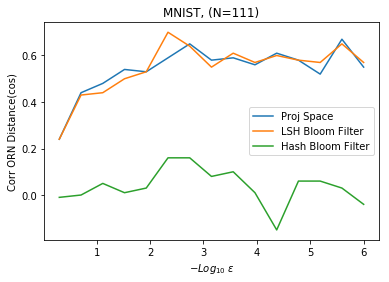

In [126]:
plt.plot(-np.log10(eps_try),T(dist_mets)[0],label='Proj Space')
plt.plot(-np.log10(eps_try),T(dist_mets)[1],label='LSH Bloom Filter')
plt.plot(-np.log10(eps_try),T(dist_mets)[2],label='Hash Bloom Filter')
# plt.semilogx(eps_try,T(dist_mets)[0],label='Proj Space')
# plt.semilogx(eps_try,T(dist_mets)[1],label='LSH Bloom Filter')
# plt.semilogx(eps_try,T(dist_mets)[2],label='Hash Bloom Filter')
plt.xlabel('$-Log_{10}$ $\epsilon$')
plt.ylabel('Corr ORN Distance(%s)' %dm)
plt.legend()
plt.title('%s, (N=%d)' %(dat_use,l_ex))
plt.show()


In [44]:
dIn = np.shape(S)[2]
if proj == 'DG':
    M = np.random.randn(dIn,m)
elif proj[:2]=='SB':
    M = T(create_projection_matrix(dIn,m,proj))
else:
    assert(0)

Sm = np.matmul(S,M) # n_ex, l_ex, m
qm = np.matmul(q,M) # n_ex, m
Sm_LSH = np.argpartition(Sm,-k)[:,:,-k:] # grab the k largest values
qm_LSH = np.argpartition(qm,-k)[:,-k:]

Sm_LSH_tag = np.zeros(np.shape(Sm))
for i,ii in np.ndenumerate(Sm_LSH):      # produce Boolean tags
    Sm_LSH_tag[i[0],i[1],ii] = 1   
    
qm_LSH_tag = np.zeros(np.shape(qm))
for i,ii in enumerate(qm_LSH):
     qm_LSH_tag[i,ii] = 1
        
# bloom filter
Sm_LSH_bloom = np.sum(Sm_LSH_tag,axis=1)>0 
avg_hash_loc = np.mean(Sm_LSH_bloom,axis=0)

# closest hash
N_LSH_tag = [-(tag_cnt(Sm_LSH_tag[i],qm_LSH_tag[i])/k-1) for i in range(n_ex)]      # Normalized
N_LSH_bloom = -(np.sum([Sm_LSH_bloom[i,qm_LSH[i]] for i in range(n_ex)],axis=1)/k-1)

# N_fly = np.zeros(n_ex)
# for i in range(n_ex):
#     N_fly[i] = fly_bloom(S=Sm_tag[i],q=qm_tag[i],rr=.01)

# Non-local hash
Sm_hash = hash_array(S,m,k)
qm_hash = hash_array(q,m,k)

Sm_hash_tag = np.zeros(np.shape(Sm))
for i,ii in np.ndenumerate(Sm_hash):      # produce Boolean tags
    Sm_hash_tag[i[0],i[1],ii] = 1   
    
qm_hash_tag = np.zeros(np.shape(qm))
for i,ii in enumerate(qm_hash):
     qm_hash_tag[i,ii] = 1
        
# non-local bloom filter
Sm_hash_bloom = np.sum(Sm_hash_tag,axis=1)>0 
avg_hash_loc = np.mean(Sm_hash_bloom,axis=0)

# closest hash
N_hash_tag = [-(tag_cnt(Sm_hash_tag[i],qm_hash_tag[i])/k-1) for i in range(n_ex)]      # Normalized
N_hash_bloom = -(np.sum([Sm_hash_bloom[i,qm_hash[i]] for i in range(n_ex)],axis=1)/k-1)


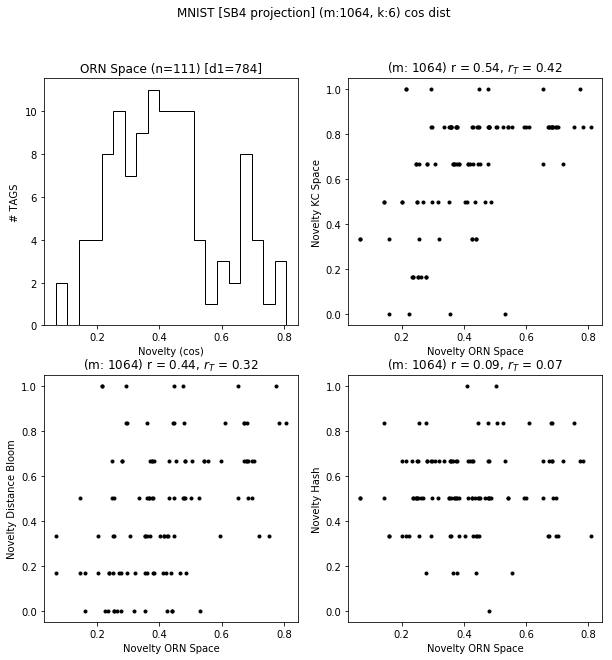

In [46]:
# variables to compare 
# - N       | ORN correlation
# - N_tag   | KC hamming distance
# - N_bloom | Bloom filter
# - N_fly   | Fly Bloom

plt.figure(figsize=(10,10))
# plt.suptitle(dat_use + ' [' + proj + ' projection]' '(m)')
plt.suptitle('%s [%s projection] (m:%d, k:%d) %s dist' %(dat_use,proj,m,k,dist_met))
plt.subplot(2,2,1)
plt.hist(N,20,histtype='step',edgecolor='k')
plt.xlabel('Novelty (' + dist_met + ')')
plt.ylabel('# TAGS')
plt.title('ORN Space (n=%d) [d1=%d]' %(l_ex,np.shape(U)[1]))

plt.subplot(2,2,2)
plt.plot(N,N_LSH_tag,'k.')

plt.title( '(m: %i) r = %.2f, $r_T$ = %.2f' %((m,) + (spearmanr(N,N_LSH_tag)[0],) + (kendalltau(N,N_LSH_tag)[0],)))
# plt.title( '(m: %i) r = %.2f, p = %.1e' %((m,) + cor_fun(N,N_tag)))
plt.ylabel('Novelty KC Space')
plt.xlabel('Novelty ORN Space')

plt.subplot(2,2,3)
plt.plot(N,N_LSH_bloom,'k.')
plt.title( '(m: %i) r = %.2f, $r_T$ = %.2f' %((m,) + (spearmanr(N,N_LSH_bloom)[0],) + (kendalltau(N,N_LSH_bloom)[0],)))
# plt.title('(m: %i) r = %.2f, p = %.1e' %((m,) + cor_fun(N,N_bloom)))
plt.ylabel('Novelty Distance Bloom')
plt.xlabel('Novelty ORN Space')

plt.subplot(2,2,4)
plt.plot(N,N_hash_bloom,'k.')
plt.title( '(m: %i) r = %.2f, $r_T$ = %.2f' %((m,) + (spearmanr(N,N_hash_bloom)[0],) + (kendalltau(N,N_hash_bloom)[0],)))
# plt.title('(m: %i) r = %.2f, p = %.1e' %((m,) + cor_fun(N,N_fly)))
plt.ylabel('Novelty Hash')
plt.xlabel('Novelty ORN Space')
plt.show()

In [65]:
def cor_fun(x1,x2):
    a1 = pearsonr(x1,x2)[0]
    a2 = kendalltau(x1,x2)[0]
    return np.round([a1,a2],2)


m_0 = '%.2f' %np.mean(N) # dist ORN space
m_1 = cor_fun(N,N_LSH_tag)
m_2 = cor_fun(N,N_LSH_bloom)
m_3 = cor_fun(N,N_hash_bloom)
foo = np.concatenate([m_1, m_2, m_3])
mPRT = 'PROJ: %.2f %.2f, LSHBLOOM: %.2f %.2f, HBLOOM %.2f %.2f' %tuple(np.concatenate([m_1, m_2, m_3]))
tuple(foo)

(0.52000000000000002,
 0.41999999999999998,
 0.42999999999999999,
 0.32000000000000001,
 0.10000000000000001,
 0.070000000000000007)

In [19]:
foo = np.round((5.050001 ,2, 3),2)
str(foo)[1:-1]

' 5.05  2.    3.  '

In [39]:
foo = '%.1e' %.005


In [64]:
mPRT

'PROJ: 0.52 0.42, LSHBLOOM: 0.43 0.32, HBLOOM 0.10 0.07'